In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp
import saxpy
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [2]:
data = df2.drop("DATETIME",1)

dfy = df2["ATT_FLAG"]
dfy = dfy.replace(-999,0)
x = []
x = pd.DataFrame(x)
for index in range(0,len(data.columns)):
    indexname = "{}".format(data.columns[index])
    dat = data[indexname].values
    amount_of_levels = 3
    window_size = 2

    discrete_signal = []
    for t in range(len(dat)-window_size):
        dat_znorm = znorm(dat[t:t+window_size])
        discrete_signal.append(ts_to_string(dat_znorm, cuts_for_asize(amount_of_levels)))

    x[indexname] = discrete_signal
saxxeddata = x   

In [3]:
saxxeddata = saxxeddata.drop("ATT_FLAG",1)

In [4]:
# saxxeddata["output"] = dfy


In [5]:
targets_for_onehot = saxxeddata.columns
new_df = pd.DataFrame([])

for target in targets_for_onehot:
    temp = pd.get_dummies(saxxeddata[target])
    new_df = pd.concat([new_df, temp],axis=1)



In [6]:
import torch
import torch.nn as nn

In [78]:
# dfy = df2["ATT_FLAG"]
# dfy = dfy.replace(-999,0)
from sklearn.model_selection import train_test_split
data= df2
datay = dfy
data = data.drop("DATETIME",axis=1)
data = data.drop("ATT_FLAG",axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(data, dfy, test_size = 0.2)
xTrain = torch.tensor(xTrain.values,dtype=torch.float)
yTrain = torch.tensor(yTrain.values,dtype=torch.float)
xTest = torch.tensor(xTest.values,dtype=torch.float)
yTest = torch.tensor(yTest.values,dtype=torch.float)


In [79]:

var = df2.drop(["DATETIME","ATT_FLAG"],axis=1).shape[1]
n_in, n_h, n_out, batch_size = var, 10, 1, 5

model = nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out),
                     nn.Sigmoid())
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
lossgraph = []
testlossgraph=[]
for epoch in range(10):
    # Forward Propagation
    y_pred = model(xTrain)
    y_pred_test = model(xTest)
    # Compute and print loss
    loss = criterion(y_pred, yTrain)
    testloss = criterion(y_pred_test,yTest)
    print('Round: ', epoch,' train loss: ', loss.item())
    print("test loss: ", testloss.item())
    
    lossgraph.append(float(loss))
    testlossgraph.append(float(testloss))
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

Round:  0  train loss:  0.9338602423667908
test loss:  0.9479416608810425
Round:  1  train loss:  0.8019454479217529
test loss:  0.8054431080818176
Round:  2  train loss:  0.3747739791870117
test loss:  0.37959760427474976
Round:  3  train loss:  0.06954064965248108
test loss:  0.05962185561656952
Round:  4  train loss:  0.054129745811223984
test loss:  0.03859209269285202
Round:  5  train loss:  0.055215414613485336
test loss:  0.039170555770397186
Round:  6  train loss:  0.055550798773765564
test loss:  0.03939159959554672
Round:  7  train loss:  0.05563797056674957
test loss:  0.039450496435165405
Round:  8  train loss:  0.055660806596279144
test loss:  0.03946603089570999
Round:  9  train loss:  0.055667705833911896
test loss:  0.03947075083851814


No handles with labels found to put in legend.


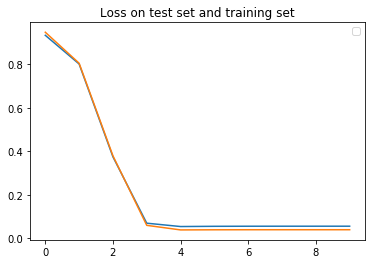

In [93]:
plt.plot(lossgraph)
plt.plot(testlossgraph)
plt.title("Loss on test set and training set")
plt.legend()

In [51]:
y_pred

tensor([[3.6255e-06],
        [1.5149e-06],
        [3.8671e-06],
        ...,
        [6.5734e-06],
        [1.4207e-04],
        [6.1290e-07]], grad_fn=<SigmoidBackward>)